In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re
from decimal import Decimal, InvalidOperation, ROUND_HALF_UP
from itertools import product
from pathlib import Path

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

## Análise do histórico de terceirizados (2010 a 2024)

### Concatenar os arquivos de 2019 a 2023 para um único dataframe por ano

In [3]:
# Caminho da pasta com os arquivos
pasta_terceirizados = Path("../../previsao_contratacao/data/terceirizados")

In [4]:
# Anos que você quer tratar
anos = [2019, 2020, 2021, 2022, 2023]

# Criar um dicionário para armazenar os dataframes por ano
dfs_por_ano = {}

In [5]:
# Iterar pelos arquivos
for arquivo in pasta_terceirizados.glob("terceirizados_*.csv"):
    nome_arquivo = arquivo.name
    try:
        ano = int(nome_arquivo.split("_")[1][:4])
    except Exception as e:
        print(f"❌ Erro ao extrair ano de {nome_arquivo}: {e}")
        continue

    if ano in anos:
        print(f"📄 Lendo: {nome_arquivo}")
        try:
            df = pd.read_csv(arquivo, sep=";", encoding="latin1", low_memory=False, dtype=str)
        except UnicodeDecodeError as e:
            print(f"⚠️ Erro de encoding em {nome_arquivo}: {e}")
            continue

        if ano not in dfs_por_ano:
            dfs_por_ano[ano] = []
        dfs_por_ano[ano].append(df)

📄 Lendo: terceirizados_202101.csv
📄 Lendo: terceirizados_202301.csv
📄 Lendo: terceirizados_202305.csv
📄 Lendo: terceirizados_202105.csv
📄 Lendo: terceirizados_202201.csv
📄 Lendo: terceirizados_202001.csv
📄 Lendo: terceirizados_201905.csv
📄 Lendo: terceirizados_201901.csv
📄 Lendo: terceirizados_202005.csv
📄 Lendo: terceirizados_202205.csv
📄 Lendo: terceirizados_202209.csv
📄 Lendo: terceirizados_202009.csv
📄 Lendo: terceirizados_201909.csv
📄 Lendo: terceirizados_202109.csv
📄 Lendo: terceirizados_202309.csv


In [6]:
# Concatenar os dataframes por ano
for ano, lista_dfs in dfs_por_ano.items():
    globals()[f"df_{ano}"] = pd.concat(lista_dfs, ignore_index=True)
    print(f"✅ df_{ano} criado com {len(globals()[f'df_{ano}'])} linhas.")

✅ df_2021 criado com 220032 linhas.
✅ df_2023 criado com 233936 linhas.
✅ df_2022 criado com 229810 linhas.
✅ df_2020 criado com 228724 linhas.
✅ df_2019 criado com 276554 linhas.


### Concatenar os arquivos de 2024 para um único dataframe

In [7]:
# Caminho da pasta com os arquivos
pasta_dados = Path("../data")

In [8]:
# Seleciona todos os arquivos que seguem o padrão terceirizados2024*.xlsx
arquivos_2024 = sorted(pasta_dados.glob("terceirizados2024*.xlsx"))

In [9]:
# Lê cada arquivo como string
dfs_2024 = []
for arquivo in arquivos_2024:
    df = pd.read_excel(arquivo, dtype=str)
    dfs_2024.append(df)

In [10]:
# Concatena todos os dataframes
df_2024 = pd.concat(dfs_2024, ignore_index=True)

In [11]:
# Remover duplicatas
df_2024 = df_2024.drop_duplicates()

In [12]:
df_2024.shape

(233344, 23)

### Tratamento dos dados de 2010 a 2024

In [13]:
df_historico = pd.read_csv("../../previsao_contratacao/data/historico_cgu/terceirizados-2010-2023.csv", sep=";", dtype=str, low_memory=False)

In [14]:
df_historico.head()

,id_terc,sg_orgao_sup_tabela_ug,cd_ug_gestora,nm_ug_tabela_ug,sg_ug_gestora,nr_contrato,nr_cnpj,nm_razao_social,nr_cpf,nm_terceirizado,...,nm_unidade_prestacao,vl_mensal_salario,vl_mensal_custo,Num_Mes_Carga,Mes_Carga,Ano_Carga,sg_orgao,nm_orgao,cd_orgao_siafi,cd_orgao_siape
0,1,MDA,490011,MINISTERIO DO DESENVOLVIMENTO AGRARIO – ADMINI...,MDA-ADM. DIRETA,68/2008,02633573000188,AJ SERVICOS LTDA,***.140.291-**,CAMILA FERNANDA ROCHA DE SOUSA,...,CONJUR,502.0,0.0,1,JANEIRO,2010,MDA,MINISTERIO DO DESENVOLVIMENTO AGRARIO,49000,42000
1,2,MDA,490011,MINISTERIO DO DESENVOLVIMENTO AGRARIO – ADMINI...,MDA-ADM. DIRETA,68/2008,02633573000188,AJ SERVICOS LTDA,***.338.161-**,DEILTON ALVES SANTANA,...,CONJUR,502.0,0.0,1,JANEIRO,2010,MDA,MINISTERIO DO DESENVOLVIMENTO AGRARIO,49000,42000
2,3,MDA,490011,MINISTERIO DO DESENVOLVIMENTO AGRARIO – ADMINI...,MDA-ADM. DIRETA,68/2008,02633573000188,AJ SERVICOS LTDA,***.532.161-**,GLEIDES MARIA DE SOUSA,...,SRA,940.0,0.0,1,JANEIRO,2010,MDA,MINISTERIO DO DESENVOLVIMENTO AGRARIO,49000,42000
3,4,MDA,490011,MINISTERIO DO DESENVOLVIMENTO AGRARIO – ADMINI...,MDA-ADM. DIRETA,68/2008,02633573000188,AJ SERVICOS LTDA,***.694.231-**,DINIS ALVES DE OLIVEIRA,...,SRA,940.0,0.0,1,JANEIRO,2010,MDA,MINISTERIO DO DESENVOLVIMENTO AGRARIO,49000,42000
4,5,MDA,490011,MINISTERIO DO DESENVOLVIMENTO AGRARIO – ADMINI...,MDA-ADM. DIRETA,68/2008,02633573000188,AJ SERVICOS LTDA,***.049.961-**,ELIETE DUARTE,...,SRA,940.0,0.0,1,JANEIRO,2010,MDA,MINISTERIO DO DESENVOLVIMENTO AGRARIO,49000,42000


In [15]:
df_historico.columns

Index(['id_terc', 'sg_orgao_sup_tabela_ug', 'cd_ug_gestora', 'nm_ug_tabela_ug',
       'sg_ug_gestora', 'nr_contrato', 'nr_cnpj', 'nm_razao_social', 'nr_cpf',
       'nm_terceirizado', 'nm_categoria_profissional', 'nm_escolaridade',
       'nr_jornada', 'nm_unidade_prestacao', 'vl_mensal_salario',
       'vl_mensal_custo', 'Num_Mes_Carga', 'Mes_Carga', 'Ano_Carga',
       'sg_orgao', 'nm_orgao', 'cd_orgao_siafi', 'cd_orgao_siape'],
      dtype='object')

In [16]:
df_historico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890255 entries, 0 to 1890254
Data columns (total 23 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   id_terc                    object
 1   sg_orgao_sup_tabela_ug     object
 2   cd_ug_gestora              object
 3   nm_ug_tabela_ug            object
 4   sg_ug_gestora              object
 5   nr_contrato                object
 6   nr_cnpj                    object
 7   nm_razao_social            object
 8   nr_cpf                     object
 9   nm_terceirizado            object
 10  nm_categoria_profissional  object
 11  nm_escolaridade            object
 12  nr_jornada                 object
 13  nm_unidade_prestacao       object
 14  vl_mensal_salario          object
 15  vl_mensal_custo            object
 16  Num_Mes_Carga              object
 17  Mes_Carga                  object
 18  Ano_Carga                  object
 19  sg_orgao                   object
 20  nm_orgao                

#### Adicionar os dados de 2019 a 2024 ao df_historico

In [17]:
df_historico_atualizado = pd.concat([df_historico, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024], ignore_index=True)

In [18]:
df_historico_atualizado = df_historico_atualizado.drop_duplicates()

In [19]:
df_historico_atualizado.shape

(3312655, 24)

#### Verificar os valores nulos

In [20]:
df_historico_atualizado.isna().sum()

id_terc                        97828
sg_orgao_sup_tabela_ug             0
cd_ug_gestora                      0
nm_ug_tabela_ug                    0
sg_ug_gestora                  26762
nr_contrato                     1760
nr_cnpj                         5304
nm_razao_social                  147
nr_cpf                             0
nm_terceirizado                   67
nm_categoria_profissional      16100
nm_escolaridade                    0
nr_jornada                         1
nm_unidade_prestacao           59520
vl_mensal_salario                 82
vl_mensal_custo                  538
Num_Mes_Carga                      1
Mes_Carga                          1
Ano_Carga                          1
sg_orgao                        1551
nm_orgao                        1551
cd_orgao_siafi                  2543
cd_orgao_siape                  1551
ï»¿id_terc                   3214827
dtype: int64

Para manter um padrão nas análises, vamos retirar os nulos de colunas que nos interessam, como: nr_cnpj e nm_categoria_profissional. Vamos retirar primeiro os nulos de nm_categoria_profissional e verificar os nulos nas outras colunas, verificar se é interessante retirar (ou se ainda tem nulos) e assim sucessivamente. Temos mais 3kk de linhas, então retirar 9450 de nm_categoria_profissional não irá impactar na análise.

In [21]:
df_historico_atualizado = df_historico_atualizado.dropna(subset=['nm_categoria_profissional'])

In [22]:
df_historico_atualizado.isna().sum()

id_terc                        97122
sg_orgao_sup_tabela_ug             0
cd_ug_gestora                      0
nm_ug_tabela_ug                    0
sg_ug_gestora                  26762
nr_contrato                     1758
nr_cnpj                         5304
nm_razao_social                  147
nr_cpf                             0
nm_terceirizado                   67
nm_categoria_profissional          0
nm_escolaridade                    0
nr_jornada                         1
nm_unidade_prestacao           59347
vl_mensal_salario                 82
vl_mensal_custo                  538
Num_Mes_Carga                      1
Mes_Carga                          1
Ano_Carga                          1
sg_orgao                        1551
nm_orgao                        1551
cd_orgao_siafi                  2543
cd_orgao_siape                  1551
ï»¿id_terc                   3199433
dtype: int64

A coluna nr_cnpj possui valores nulos e é uma coluna importante para análise, por isso vamos retirar os nulos dessa linha também.

In [23]:
df_historico_atualizado = df_historico_atualizado.dropna(subset=['nr_cnpj'])

In [24]:
df_historico_atualizado.isna().sum()

id_terc                        97122
sg_orgao_sup_tabela_ug             0
cd_ug_gestora                      0
nm_ug_tabela_ug                    0
sg_ug_gestora                  26701
nr_contrato                     1758
nr_cnpj                            0
nm_razao_social                    1
nr_cpf                             0
nm_terceirizado                   67
nm_categoria_profissional          0
nm_escolaridade                    0
nr_jornada                         1
nm_unidade_prestacao           57859
vl_mensal_salario                 80
vl_mensal_custo                  536
Num_Mes_Carga                      1
Mes_Carga                          1
Ano_Carga                          1
sg_orgao                        1491
nm_orgao                        1491
cd_orgao_siafi                  2483
cd_orgao_siape                  1491
ï»¿id_terc                   3194129
dtype: int64

Há outras três colunas importantes para as análises: vl_mensal_salario, vl_mensal_custo e Ano_Carga. As duas primeiras vão nos permitir identificar padrões salariais de cada categoria profissional e também o custo de cada posto par as empresas. No caso de Ano_Carga será importante para identificar padrões ao longo dos anos. Por isso será importante retirar os nulos que aparecem nessas colunas.

In [25]:
df_historico_atualizado = df_historico_atualizado.dropna(subset=['vl_mensal_salario', 'vl_mensal_custo', 'Ano_Carga'])

In [26]:
df_historico_atualizado.isna().sum()

id_terc                        97122
sg_orgao_sup_tabela_ug             0
cd_ug_gestora                      0
nm_ug_tabela_ug                    0
sg_ug_gestora                  26681
nr_contrato                     1758
nr_cnpj                            0
nm_razao_social                    1
nr_cpf                             0
nm_terceirizado                   67
nm_categoria_profissional          0
nm_escolaridade                    0
nr_jornada                         0
nm_unidade_prestacao           57858
vl_mensal_salario                  0
vl_mensal_custo                    0
Num_Mes_Carga                      0
Mes_Carga                          0
Ano_Carga                          0
sg_orgao                        1490
nm_orgao                        1490
cd_orgao_siafi                  2482
cd_orgao_siape                  1490
ï»¿id_terc                   3193593
dtype: int64

### Transformar os dados para as análises

In [27]:
df_historico_atualizado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3290715 entries, 0 to 3312654
Data columns (total 24 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   id_terc                    object
 1   sg_orgao_sup_tabela_ug     object
 2   cd_ug_gestora              object
 3   nm_ug_tabela_ug            object
 4   sg_ug_gestora              object
 5   nr_contrato                object
 6   nr_cnpj                    object
 7   nm_razao_social            object
 8   nr_cpf                     object
 9   nm_terceirizado            object
 10  nm_categoria_profissional  object
 11  nm_escolaridade            object
 12  nr_jornada                 object
 13  nm_unidade_prestacao       object
 14  vl_mensal_salario          object
 15  vl_mensal_custo            object
 16  Num_Mes_Carga              object
 17  Mes_Carga                  object
 18  Ano_Carga                  object
 19  sg_orgao                   object
 20  nm_orgao                

Os dados estão como tipo object, precisamos transformá-los para fazerem sentido nas análises.

In [28]:
def limpar_valor(val):
    if pd.isna(val):
        return np.nan
    val = str(val).strip()
    # Remove espaços e símbolos como R$, etc.
    val = re.sub(r"[^\d,.-]", "", val)

    # Se houver mais de uma vírgula, provavelmente é separador de milhar → remove todas
    if val.count(",") > 1:
        val = val.replace(",", "")
    # Se houver uma vírgula e nenhum ponto, é separador decimal
    elif val.count(",") == 1 and val.count(".") == 0:
        val = val.replace(",", ".")
    # Se houver ponto como milhar e vírgula como decimal (ex: 1.234,56)
    elif "." in val and "," in val and val.find(".") < val.find(","):
        val = val.replace(".", "").replace(",", ".")
    else:
        val = val.replace(",", "")

    try:
        return round(float(val), 2)
    except ValueError:
        return np.nan

In [29]:
df_historico_atualizado["vl_mensal_salario"] = df_historico_atualizado["vl_mensal_salario"].apply(limpar_valor)
df_historico_atualizado["vl_mensal_custo"] = df_historico_atualizado["vl_mensal_custo"].apply(limpar_valor)

In [30]:
# Corrige valores não numéricos e vírgulas como separador decimal
df_historico_atualizado['nr_jornada'] = (
    df_historico_atualizado['nr_jornada']
    .astype(str)
    .str.strip()
    .replace(['NI', 'NI.', 'NI  ', 'nan', 'NaN'], np.nan)
    .str.replace(',', '.', regex=False)
)

# Converte para float e depois para inteiro, preservando nulos
df_historico_atualizado['nr_jornada'] = (
    pd.to_numeric(df_historico_atualizado['nr_jornada'], errors='coerce')
    .round()
    .astype('Int64')
)

In [31]:
# Visualizar os maiores salários
print("Salários muito altos:")
display(df_historico_atualizado[df_historico_atualizado['vl_mensal_salario'].astype(str).str.replace('.', '', regex=False).str.contains(r'\d{6,}')][['vl_mensal_salario']].drop_duplicates().sort_values(by='vl_mensal_salario', ascending=False).head(20))

# Visualizar os maiores custos
print("\nCustos muito altos:")
display(df_historico_atualizado[df_historico_atualizado['vl_mensal_custo'].astype(str).str.replace('.', '', regex=False).str.contains(r'\d{6,}')][['vl_mensal_custo']].drop_duplicates().sort_values(by='vl_mensal_custo', ascending=False).head(20))

Salários muito altos:


,vl_mensal_salario
858412,"81,200,840.00"
1622857,"9,854,700.00"
111670,"7,231,522.00"
2826958,"270,623.00"
1642339,"247,469.00"
1645910,"247,228.00"
287682,"228,693.00"
2826959,"223,328.00"
3123507,"212,734.00"
287685,"203,528.00"



Custos muito altos:


,vl_mensal_custo
858412,"2,492,772,864.00"
1011293,"226,455,872.00"
1622857,"24,949,100.00"
111670,"16,903,766.00"
887133,"3,730,417.25"
935517,"3,586,974.75"
1370628,"3,491,480.50"
879056,"3,395,914.50"
913507,"3,282,188.75"
880500,"3,264,197.25"


In [32]:
# Salários muito altos (ex: acima de R$ 30 mil)
salarios_suspeitos = df_historico_atualizado[df_historico_atualizado['vl_mensal_salario'] > 30000]

print(f"Total de salários suspeitos: {salarios_suspeitos.shape[0]}")
display(salarios_suspeitos[['vl_mensal_salario', 'vl_mensal_custo', 'nm_categoria_profissional', 'Ano_Carga']].sort_values('vl_mensal_salario', ascending=False).head(20))

Total de salários suspeitos: 216


,vl_mensal_salario,vl_mensal_custo,nm_categoria_profissional,Ano_Carga
858412,"81,200,840.00","2,492,772,864.00",AUXILIAR DE JARDINAGEM,2014
1622857,"9,854,700.00","24,949,100.00",514320 - FAXINEIRO,2017
1807337,"9,854,700.00","24,949,100.00",514320 - FAXINEIRO,2018
111670,"7,231,522.00","16,903,766.00",DIRETORES GERAIS,2010
2826963,"270,623.00","541,246.00",517330 - VIGILANTE,2022
2826962,"270,623.00","541,246.00",517330 - VIGILANTE,2022
2826961,"270,623.00","541,246.00",517330 - VIGILANTE,2022
2826958,"270,623.00","541,246.00",517330 - VIGILANTE,2022
1642556,"247,469.00","503,279.00",517330 - VIGILANTE,2017
1806832,"247,469.00","503,279.00",517330 - VIGILANTE,2018


In [33]:
# Mesmo após diversas tentativas de limpezas e tratamento, ainda há valores discrepantes que, provavelmente, são provenientes de erro de preenchimento, assim vamos retirar esses valores (216)

# Limites plausíveis
limite_salario = 100_000
limite_custo = 200_000

# Filtra os dados com valores aceitáveis
df_historico_atualizado_filtrado = df_historico_atualizado[
    (df_historico_atualizado['vl_mensal_salario'] <= limite_salario) &
    (df_historico_atualizado['vl_mensal_custo'] <= limite_custo)
].copy()

In [34]:
print(df_historico_atualizado_filtrado['vl_mensal_salario'].describe())
print(df_historico_atualizado_filtrado['vl_mensal_custo'].describe())

count   3,289,756.00
mean        1,646.38
std         1,359.13
min             0.00
25%           957.00
50%         1,293.37
75%         1,850.00
max       100,000.00
Name: vl_mensal_salario, dtype: float64
count   3,289,756.00
mean        4,194.24
std         3,245.11
min             0.00
25%         2,374.16
50%         3,484.00
75%         4,956.43
max       193,424.00
Name: vl_mensal_custo, dtype: float64


In [35]:
print("Maior salário:", df_historico_atualizado_filtrado['vl_mensal_salario'].max())
print("Maior custo mensal:", df_historico_atualizado_filtrado['vl_mensal_custo'].max())

Maior salário: 100000.0
Maior custo mensal: 193424.0


In [36]:
df_historico_atualizado_filtrado['nr_jornada'].describe()

count   3,280,585.00
mean           41.60
std             4.12
min             3.00
25%            40.00
50%            44.00
75%            44.00
max            96.00
Name: nr_jornada, dtype: Float64

In [37]:
df_historico_atualizado_filtrado['vl_mensal_custo'].describe()

count   3,289,756.00
mean        4,194.24
std         3,245.11
min             0.00
25%         2,374.16
50%         3,484.00
75%         4,956.43
max       193,424.00
Name: vl_mensal_custo, dtype: float64

In [38]:
df_historico_atualizado_filtrado['vl_mensal_salario'].describe()

count   3,289,756.00
mean        1,646.38
std         1,359.13
min             0.00
25%           957.00
50%         1,293.37
75%         1,850.00
max       100,000.00
Name: vl_mensal_salario, dtype: float64

In [39]:
df_historico_atualizado_filtrado['Ano_Carga'].unique()

array(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022', '2023', '2024'],
      dtype=object)

### Quantidade de terceirizados por ano de carga na CGU

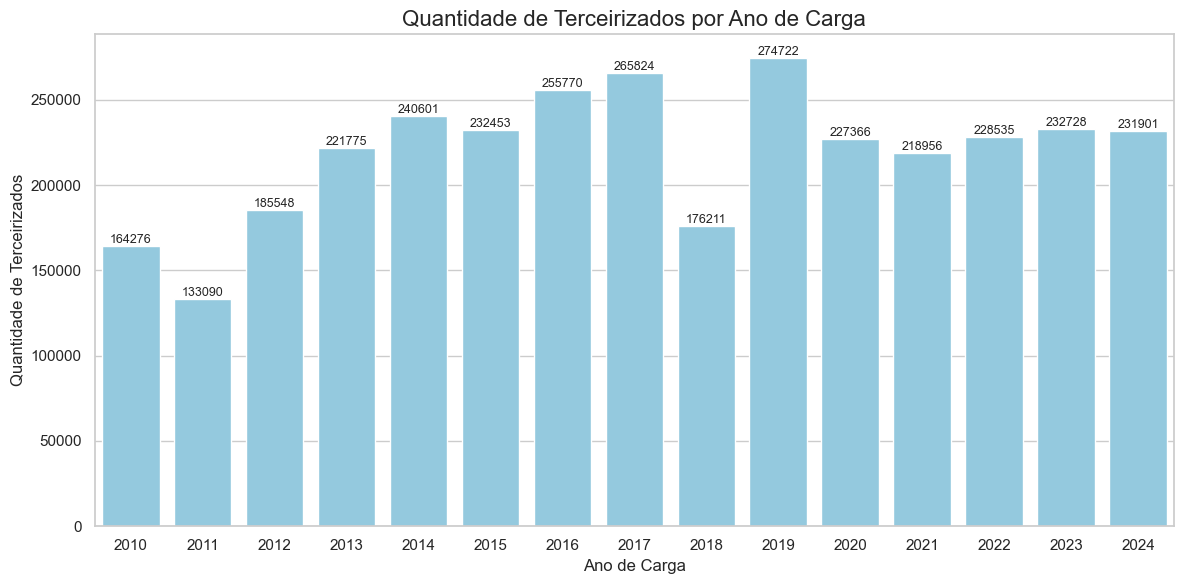

In [41]:
# Estilo bonito
sns.set(style="whitegrid")

# Contagem de terceirizados por ano
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_historico_atualizado_filtrado, x="Ano_Carga", color='skyblue')

# Títulos e rótulos
ax.set_title("Quantidade de Terceirizados por Ano de Carga", fontsize=16)
ax.set_xlabel("Ano de Carga", fontsize=12)
ax.set_ylabel("Quantidade de Terceirizados", fontsize=12)

# Adiciona os valores no topo das barras, como inteiros
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
    
# Caminho e nome do arquivo
#plt.savefig("./graficos/quantidade_terceirizados_por_ano.png", dpi=300)  # Salva em alta resolução

plt.show()

### Categorias profissionais com a maior quantidade por ano

#### Tratar os códigos da CBO para que todas tenham e seja possível agrupar posteriormente

In [42]:
df_historico_atualizado_filtrado['nm_categoria_profissional'].value_counts(dropna=False).head(30)

517330 - VIGILANTE                                                             342108
514320 - FAXINEIRO                                                             330235
VIGILANTE                                                                      277376
SERVENTE                                                                       102327
AUXILIAR DE SERVICOS GERAIS                                                    101277
422105 - RECEPCIONISTA, EM GERAL                                                97853
411010 - ASSISTENTE ADMINISTRATIVO                                              79259
411005 - AUXILIAR DE ESCRITORIO                                                 77164
RECEPCIONISTA                                                                   74678
422310 - OPERADOR DE TELEMARKETING ATIVO E RECEPTIVO                            61461
SERVENTE DE LIMPEZA                                                             49318
422305 - OPERADOR DE TELEMARKETING ATIVO              

In [43]:
df_cbo = pd.read_csv('../data/CBO2002 - Ocupacao.csv', dtype=str, sep=';', encoding='latin1')

In [44]:
df_cbo.head()

,CODIGO,TITULO
0,010105,Oficial general da aeronáutica
1,010110,Oficial general do exército
2,010115,Oficial general da marinha
3,010205,Oficial da aeronáutica
4,010210,Oficial do exército


In [45]:
# Extrai o código e o nome para registros que possuem CBO no formato "código - título"
df_historico_atualizado_filtrado["cbo_codigo"] = df_historico_atualizado_filtrado["nm_categoria_profissional"].str.extract(r"^(\d{4,6})\s*-\s*")[0]
df_historico_atualizado_filtrado["cbo_titulo"] = df_historico_atualizado_filtrado["nm_categoria_profissional"].str.replace(r"^\d{4,6}\s*-\s*", "", regex=True).str.strip()

In [46]:
# Para os registros que não têm código, tenta buscar o código CBO pelo nome normalizado
df_cbo["TITULO"] = df_cbo["TITULO"].str.strip().str.upper()
df_cbo["CODIGO"] = df_cbo["CODIGO"].astype(str).str.zfill(6)

In [47]:
# Normaliza para facilitar comparação
df_historico_atualizado_filtrado["cbo_titulo_normalizado"] = df_historico_atualizado_filtrado["cbo_titulo"].str.upper().str.strip()

In [48]:
# Divide entre os que já têm código e os que ainda não têm
df_com_cbo = df_historico_atualizado_filtrado[~df_historico_atualizado_filtrado["cbo_codigo"].isna()].copy()
df_sem_cbo = df_historico_atualizado_filtrado[df_historico_atualizado_filtrado["cbo_codigo"].isna()].copy()

In [49]:
# Faz merge com dicionário CBO nos que não tinham código, usando o nome
df_sem_cbo = df_sem_cbo.merge(
    df_cbo,
    left_on="cbo_titulo_normalizado",
    right_on="TITULO",
    how="left"
)

In [50]:
# Preenche o código e título nos que foram encontrados
df_sem_cbo.loc[df_sem_cbo["CODIGO"].notna(), "cbo_codigo"] = df_sem_cbo["CODIGO"]
df_sem_cbo.loc[df_sem_cbo["CODIGO"].notna(), "cbo_titulo"] = df_sem_cbo["TITULO"]

In [51]:
# Concatena tudo novamente
df_final_cbo = pd.concat([df_com_cbo, df_sem_cbo], ignore_index=True)

# Remove colunas auxiliares
df_final_cbo.drop(columns=["CODIGO", "TITULO", "cbo_titulo_normalizado"], inplace=True, errors="ignore")

In [52]:
df_final_cbo.head()

,id_terc,sg_orgao_sup_tabela_ug,cd_ug_gestora,nm_ug_tabela_ug,sg_ug_gestora,nr_contrato,nr_cnpj,nm_razao_social,nr_cpf,nm_terceirizado,...,Num_Mes_Carga,Mes_Carga,Ano_Carga,sg_orgao,nm_orgao,cd_orgao_siafi,cd_orgao_siape,ï»¿id_terc,cbo_codigo,cbo_titulo
0,6573172,MDSA,511325,GERENCIA EXECUTIVA SAO PAULO CENTRO,GEX/SP-CENTRO,83/2011,50400407000184,PROVAC TERCEIRIZACAO DE MAO DE OBRA LTDA,***.392.438-**,ANGELICA ABREU DA SILVA,...,5,MAIO,2017,INSS,INSTITUTO NACIONAL DO SEGURO SOCIAL,37202,57202,NaN,514320,FAXINEIRO
1,6573173,MAPA,130005,COORDENACAO-GERAL DE RECURSOS LOGISTICOS,CGOEF/DA/SE/MAPA,014/2013,00588541000182,IPANEMAEMPRESA DE SERVICOS GERIAS E TRANSPORTE...,***.237.801-**,RILZA RAMOS,...,5,MAIO,2017,MIN.AGRICULTURA,"MINIST. DA AGRICUL.,PECUARIA E ABASTECIMENTO",22000,13000,NaN,513425,COPEIRO
2,6573174,MEC,153061,UNIVERSIDADE FEDERAL DE JUIZ DE FORA,UFJF,25/2016,04552404000149,ADCON ADMINISTRACAO E CONSERVACAO EIRELI,***.855.641-**,JOSE CARLOS DE SOUZA SAVERIO,...,5,MAIO,2017,UFJF,UNIVERSIDADE FEDERAL DE JUIZ DE FORA,26237,26237,NaN,5174,"PORTEIROS, VIGIAS E AFINS"
3,6573175,MEC,153115,UNIVERSIDADE FEDERAL DO ESTADO DO RIO DE JANEIRO,UFRJ,59/2016,09445502000109,SOLUCOES SERVICOS TERCEIRIZADOS EIRELI,***.718.397-**,CELIA ROSANA DE OLIVEIRA,...,5,MAIO,2017,UFRJ,UNIVERSIDADE FEDERAL DO RIO DE JANEIRO,26245,26245,NaN,514320,FAXINEIRO
4,6573176,MEC,153079,UNIVERSIDADE FEDERAL DO PARANA,UFPR,086/2016,79283065000303,ORBENK ADMINISTRACAO E SERVICOS LTDA,***.158.869-**,FABIANI MENEZES ROSA BARBOSA,...,5,MAIO,2017,UFPR,UNIVERSIDADE FEDERAL DO PARANA,26241,26241,NaN,410105,SUPERVISOR ADMINISTRATIVO


In [53]:
# Agrupa por ano e categoria profissional e conta o número de registros
df_top_categorias = (
    df_final_cbo
    .groupby(['Ano_Carga', 'cbo_titulo'])
    .size()
    .reset_index(name='qtd_terceirizados')
)

# Para cada ano, pega as 3 categorias com mais contratações
top_3_por_ano = (
    df_top_categorias
    .sort_values(['Ano_Carga', 'qtd_terceirizados'], ascending=[True, False])
    .groupby('Ano_Carga')
    .head(3)
    .reset_index(drop=True)
)

In [54]:
# Garante que 'Ano_Carga' seja tratado como string categórica ordenada
top_3_por_ano["Ano_Carga"] = top_3_por_ano["Ano_Carga"].astype(str)
anos_ordenados = sorted(top_3_por_ano["Ano_Carga"].unique())
top_3_por_ano["Ano_Carga"] = pd.Categorical(top_3_por_ano["Ano_Carga"], categories=anos_ordenados, ordered=True)

In [55]:
# Trata 'cbo_titulo' como categoria para evitar desalinhamento por string
top_3_por_ano["cbo_titulo"] = top_3_por_ano["cbo_titulo"].astype("category")

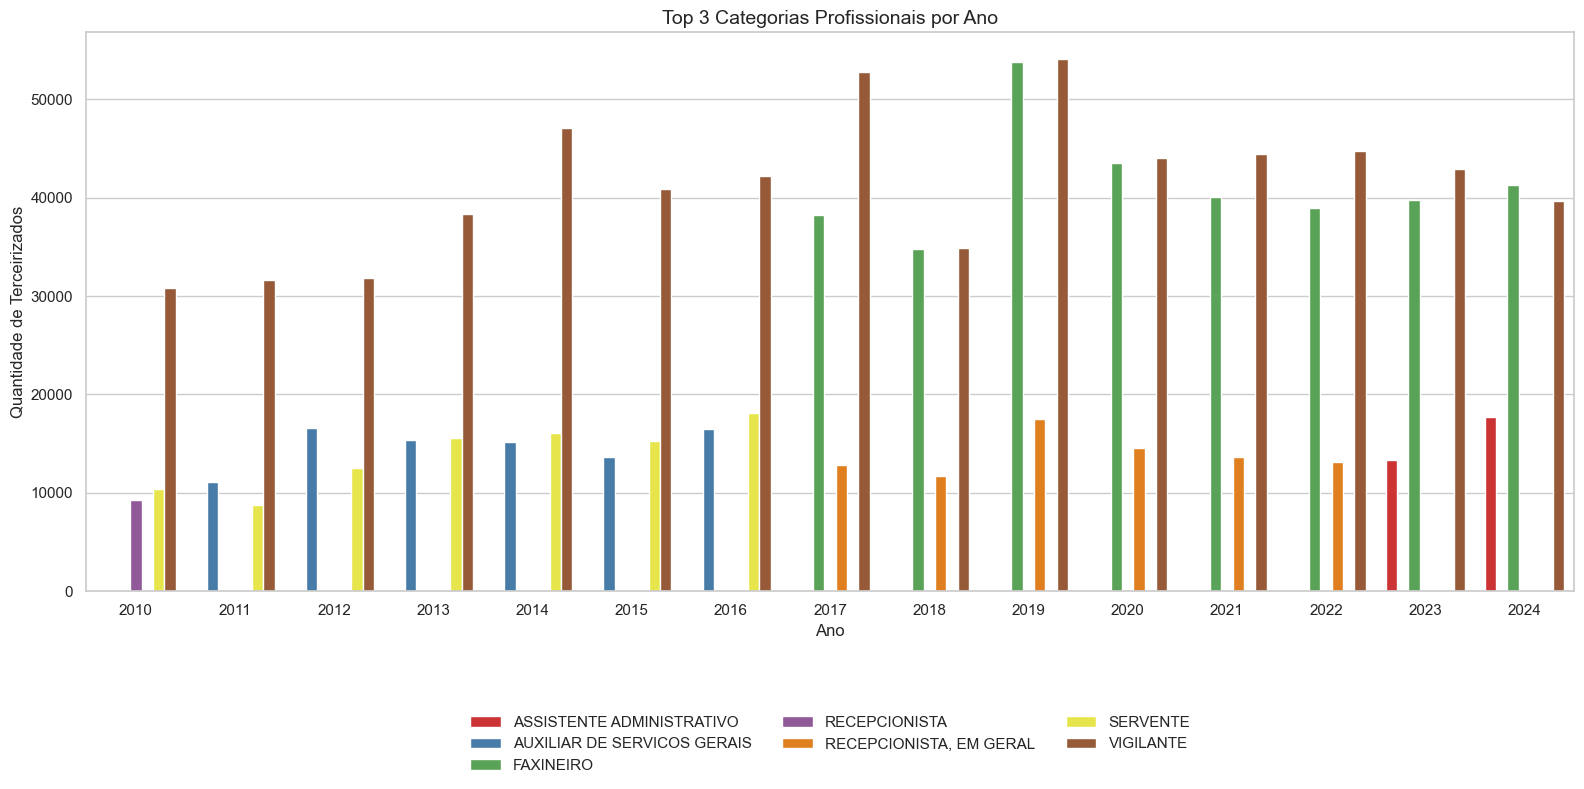

In [57]:
plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_3_por_ano,
    x="Ano_Carga",
    y="qtd_terceirizados",
    hue="cbo_titulo",
    dodge=True,
    palette="Set1"
)

plt.title("Top 3 Categorias Profissionais por Ano", fontsize=14)
plt.ylabel("Quantidade de Terceirizados")
plt.xlabel("Ano")

plt.legend(
    title=None,
    bbox_to_anchor=(0.5, -0.35),
    loc='lower center',
    ncol=3,
    frameon=False
)

plt.subplots_adjust(bottom=0.2)

plt.tight_layout()

# Caminho e nome do arquivo
#plt.savefig("./graficos/top3_categ_profissionais_ano.png", dpi=300)  # Salva em alta resolução

plt.show()

### Órgãos com a maior contratação de terceirizados por ano

In [58]:
df_final_cbo["sg_orgao_sup_tabela_ug"].value_counts()

MEC         865187
MIN.EDUC    462896
MPS         221054
ME.         178440
MS          164215
MINISTER    138718
MF          120028
MJSP         94582
MT           77117
MCTI         74658
MDS          71143
MINC         67026
MMA          54157
MTP          48931
MJ           48089
M.J          37543
MAPA         37246
MGI          34031
MC           32056
MDA          29568
MIN.AGRI     27342
MTPAC        26534
MME          26363
MI           25631
MDIC         25543
M.INFRAE     21814
MPOG         21622
MDSA         20939
MINIST.      20923
MCTIC        18929
PR           17988
MTPS         17751
BACEN-OR     17746
MTR          16587
M.CIDADA     15543
MCT          15105
MCOM         14145
MTE          12827
MDR          12815
MIN. MEI      7290
MCIDADES      6807
MICES         6228
MIDR          5953
MDICS         5880
MPO           4250
MTB           4078
ME            3836
MPDG          3399
MTUR          3324
MPA           3183
MPI            961
MFAZ           956
MP.         

In [59]:
df_final_cbo[df_final_cbo["sg_orgao_sup_tabela_ug"] == "MTP"]

,id_terc,sg_orgao_sup_tabela_ug,cd_ug_gestora,nm_ug_tabela_ug,sg_ug_gestora,nr_contrato,nr_cnpj,nm_razao_social,nr_cpf,nm_terceirizado,...,Num_Mes_Carga,Mes_Carga,Ano_Carga,sg_orgao,nm_orgao,cd_orgao_siafi,cd_orgao_siape,ï»¿id_terc,cbo_codigo,cbo_titulo
1122016,8271406,MTP,510180,SUPERINTENDENCIA REGIONAL SUDESTE II,SUPER SUDESTE II,08/2019,20522050000146,ESPECIALY TERCEIRIZACAO EIRELI,***.041.567-**,ANA LUCIA DA SILVA,...,1,JANEIRO,2022,INSS,INSTITUTO NACIONAL DO SEGURO SOCIAL,37202,57202,NaN,514320,FAXINEIRO
1122017,8271407,MTP,510180,SUPERINTENDENCIA REGIONAL SUDESTE II,SUPER SUDESTE II,08/2019,20522050000146,ESPECIALY TERCEIRIZACAO EIRELI,***.400.847-**,ROSE ADRIANE VIRGILIO ROSA,...,1,JANEIRO,2022,INSS,INSTITUTO NACIONAL DO SEGURO SOCIAL,37202,57202,NaN,514320,FAXINEIRO
1122018,8271408,MTP,510180,SUPERINTENDENCIA REGIONAL SUDESTE II,SUPER SUDESTE II,08/2019,20522050000146,ESPECIALY TERCEIRIZACAO EIRELI,***.454.957-**,SILVANE MARIA DE ALMEIDA,...,1,JANEIRO,2022,INSS,INSTITUTO NACIONAL DO SEGURO SOCIAL,37202,57202,NaN,514320,FAXINEIRO
1122019,8271409,MTP,510180,SUPERINTENDENCIA REGIONAL SUDESTE II,SUPER SUDESTE II,08/2019,20522050000146,ESPECIALY TERCEIRIZACAO EIRELI,***.597.157-**,SONIA DA CONCEICAO PEIXOTO,...,1,JANEIRO,2022,INSS,INSTITUTO NACIONAL DO SEGURO SOCIAL,37202,57202,NaN,514320,FAXINEIRO
1122020,8271410,MTP,510180,SUPERINTENDENCIA REGIONAL SUDESTE II,SUPER SUDESTE II,08/2019,20522050000146,ESPECIALY TERCEIRIZACAO EIRELI,***.154.347-**,ALEX SANDRO BELIZARIO DE MOURA,...,1,JANEIRO,2022,INSS,INSTITUTO NACIONAL DO SEGURO SOCIAL,37202,57202,NaN,514320,FAXINEIRO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308978,8442901,MTP,512074,SUPERINTENDENCIA REGIONAL SUDESTE III,GEX/R.J.NORTE,19/2020,00118039000108,AIGLE EMPREENDIMENTOS LTDA,***.949.077-**,ADRIANO ROCHA DE MATTOS,...,9,SETEMBRO,2022,INSS,INSTITUTO NACIONAL DO SEGURO SOCIAL,37202,57202,NaN,514325,TRABALHADOR DA MANUTENCAO DE EDIFICACOES
1308979,8442902,MTP,512074,SUPERINTENDENCIA REGIONAL SUDESTE III,GEX/R.J.NORTE,19/2020,00118039000108,AIGLE EMPREENDIMENTOS LTDA,***.864.907-**,WESLEY RAMIREZ MELONI DA SILVA,...,9,SETEMBRO,2022,INSS,INSTITUTO NACIONAL DO SEGURO SOCIAL,37202,57202,NaN,514310,AUXILIAR DE MANUTENCAO PREDIAL
1308980,8442903,MTP,512074,SUPERINTENDENCIA REGIONAL SUDESTE III,GEX/R.J.NORTE,19/2020,00118039000108,AIGLE EMPREENDIMENTOS LTDA,***.132.156-**,SEBASTIAO LUCINDO,...,9,SETEMBRO,2022,INSS,INSTITUTO NACIONAL DO SEGURO SOCIAL,37202,57202,NaN,514310,AUXILIAR DE MANUTENCAO PREDIAL
1308981,8442904,MTP,512074,SUPERINTENDENCIA REGIONAL SUDESTE III,GEX/R.J.NORTE,19/2020,00118039000108,AIGLE EMPREENDIMENTOS LTDA,***.640.197-**,JONAS CUSTODIO DE SOUZA,...,9,SETEMBRO,2022,INSS,INSTITUTO NACIONAL DO SEGURO SOCIAL,37202,57202,NaN,514310,AUXILIAR DE MANUTENCAO PREDIAL


In [60]:
df_final_cbo[df_final_cbo["sg_orgao_sup_tabela_ug"] == "MT"]

,id_terc,sg_orgao_sup_tabela_ug,cd_ug_gestora,nm_ug_tabela_ug,sg_ug_gestora,nr_contrato,nr_cnpj,nm_razao_social,nr_cpf,nm_terceirizado,...,Num_Mes_Carga,Mes_Carga,Ano_Carga,sg_orgao,nm_orgao,cd_orgao_siafi,cd_orgao_siape,ï»¿id_terc,cbo_codigo,cbo_titulo
1781577,7983,MT,393001,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES - ANTT,ANTT,010/2005,38061495000131,POLO ENGENHARIA LTDA.,***.401.216-**,CARLOS EDUARDO CORREA,...,1,JANEIRO,2010,ANTT,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES,39250,39250,NaN,NaN,ENGENHEIRO MECANICO
1781578,7984,MT,393001,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES - ANTT,ANTT,010/2005,38061495000131,POLO ENGENHARIA LTDA.,***.022.501-**,SEBASTIAO RODRIGUES CAMPOS,...,1,JANEIRO,2010,ANTT,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES,39250,39250,NaN,NaN,MECANICO
1781579,7985,MT,393001,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES - ANTT,ANTT,010/2005,38061495000131,POLO ENGENHARIA LTDA.,***.626.181-**,JUAN DE SOUZA COUTO,...,1,JANEIRO,2010,ANTT,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES,39250,39250,NaN,NaN,AJUDANTE DE MECANICA
1781580,7986,MT,393001,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES - ANTT,ANTT,031/2006,01092071000205,CORAL ADMINTRACAO E SERVICOS LTDA,***.798.601-**,OSVALDO RODRIGUIS CERQUEIRA,...,1,JANEIRO,2010,ANTT,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES,39250,39250,NaN,NaN,SUPERVISOR DE BRIGADA
1781581,7987,MT,393001,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES - ANTT,ANTT,031/2006,01092071000205,CORAL ADMINTRACAO E SERVICOS LTDA,***.770.401-**,LEVI MACHADO ROSA,...,1,JANEIRO,2010,ANTT,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES,39250,39250,NaN,517125,CHEFE DE BRIGADA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132123,6414922,MT,390004,MINISTERIO DOS TRANSPORTES,CGRL,31/2015,03873484000171,EMPREZA GESTAO DE PESSOAS E SERVICOS LTDA,***.887.203-**,LICIA MAGDA FRANCA LINO,...,5,MAIO,2016,M.T.,MINISTERIO DOS TRANSPORTES,39000,49000,NaN,NaN,ASSISTENTE TECNICO ADMINISTRATIVO PLENO
3132130,6414929,MT,393001,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES - ANTT,ANTT,041/2014,07094346000145,G4F SOLUCOES CORPORTATIVAS LTDA,***.332.951-**,HELTON BATISTA SOUSA,...,5,MAIO,2016,ANTT,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES,39250,39250,NaN,NaN,AUXILIAR ADMINISTRATIVO
3132242,6415042,MT,393038,UNIDADE REGIONAL DO RIO DE JANEIRO - ANTT/URRJ,URRJ,025/2014,04086371000199,TRANS-EXPERT TRANSPORTE DE VALORES E SEGURANCA...,***.581.867-**,RODOLFO MAIA MARINHO,...,5,MAIO,2016,ANTT,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES,39250,39250,NaN,NaN,VIGILANTE
3132243,6415043,MT,390004,MINISTERIO DOS TRANSPORTES,CGRL,40/2014,02843359000156,PLANALTO SERVICE LTDA,***.972.961-**,LAURENI RODRIGUES DO NASCIMENTO,...,5,MAIO,2016,M.T.,MINISTERIO DOS TRANSPORTES,39000,49000,NaN,513425,COPEIRO


In [61]:
df_final_cbo[df_final_cbo["sg_orgao_sup_tabela_ug"] == "MINISTER"]

,id_terc,sg_orgao_sup_tabela_ug,cd_ug_gestora,nm_ug_tabela_ug,sg_ug_gestora,nr_contrato,nr_cnpj,nm_razao_social,nr_cpf,nm_terceirizado,...,Num_Mes_Carga,Mes_Carga,Ano_Carga,sg_orgao,nm_orgao,cd_orgao_siafi,cd_orgao_siape,ï»¿id_terc,cbo_codigo,cbo_titulo
404463,8047105,MINISTER,253012,COORDENACAO REGIONAL DE VIGILANCIA SANITARIA D...,CVSPAF-RJ/ANVISA,05/2010,10565981000178,LINCE SEGURANCA ELETRONICA LTDA,***.861.917-**,ROSENI SILVA BAHIENSE,...,5,MAIO,2019,ANVS,AGENCIA NACIONAL DE VIGILANCIA SANITARIA,36212,36207,NaN,514320,FAXINEIRO
404464,8047106,MINISTER,253012,COORDENACAO REGIONAL DE VIGILANCIA SANITARIA D...,CVSPAF-RJ/ANVISA,05/2010,10565981000178,LINCE SEGURANCA ELETRONICA LTDA,***.110.687-**,GILSON CAMPOS,...,5,MAIO,2019,ANVS,AGENCIA NACIONAL DE VIGILANCIA SANITARIA,36212,36207,NaN,514320,FAXINEIRO
404465,8047107,MINISTER,253012,COORDENACAO REGIONAL DE VIGILANCIA SANITARIA D...,CVSPAF-RJ/ANVISA,05/2017,00482840000138,LIDERANCA LIMPEZA E CONSERVACAO LTDA,***.264.727-**,MIRIAN PINTO VICTORINO,...,5,MAIO,2019,ANVS,AGENCIA NACIONAL DE VIGILANCIA SANITARIA,36212,36207,NaN,351505,TECNICO EM SECRETARIADO
404466,8047108,MINISTER,253012,COORDENACAO REGIONAL DE VIGILANCIA SANITARIA D...,CVSPAF-RJ/ANVISA,05/2017,00482840000138,LIDERANCA LIMPEZA E CONSERVACAO LTDA,***.235.917-**,LUZIA PINHEIRO DE FREITAS,...,5,MAIO,2019,ANVS,AGENCIA NACIONAL DE VIGILANCIA SANITARIA,36212,36207,NaN,351505,TECNICO EM SECRETARIADO
404467,8047109,MINISTER,253012,COORDENACAO REGIONAL DE VIGILANCIA SANITARIA D...,CVSPAF-RJ/ANVISA,05/2017,00482840000138,LIDERANCA LIMPEZA E CONSERVACAO LTDA,***.490.107-**,MORENY VICTORINO,...,5,MAIO,2019,ANVS,AGENCIA NACIONAL DE VIGILANCIA SANITARIA,36212,36207,NaN,351505,TECNICO EM SECRETARIADO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765849,8886570,MINISTER,254420,FIOCRUZ,FIOCRUZ/PRESIDENCIA,708/2023,29212545000143,NOVA RIO SERVICOS GERAIS LTDA,***.361.587-**,LEANDRO DE OLIVEIRA FERRAZ,...,9,SETEMBRO,2024,FIOCRUZ,FUNDACAO OSWALDO CRUZ,36201,36201,NaN,314110,TECNICO MECANICO
1765850,8886571,MINISTER,254420,FIOCRUZ,FIOCRUZ/PRESIDENCIA,708/2023,29212545000143,NOVA RIO SERVICOS GERAIS LTDA,***.395.767-**,RAPHAEL PINHEIRO FONSECA,...,9,SETEMBRO,2024,FIOCRUZ,FUNDACAO OSWALDO CRUZ,36201,36201,NaN,301105,TECNICO DE LABORATORIO INDUSTRIAL
1765851,8886572,MINISTER,254420,FIOCRUZ,FIOCRUZ/PRESIDENCIA,708/2023,29212545000143,NOVA RIO SERVICOS GERAIS LTDA,***.418.807-**,VERONICA MEIRELES DA COSTA XIMENES,...,9,SETEMBRO,2024,FIOCRUZ,FUNDACAO OSWALDO CRUZ,36201,36201,NaN,2124,ANALISTAS DE TECNOLOGIA DA INFORMACAO
1765852,8886573,MINISTER,254420,FIOCRUZ,FIOCRUZ/PRESIDENCIA,708/2023,29212545000143,NOVA RIO SERVICOS GERAIS LTDA,***.648.717-**,AMANDA DE MIRANDA MARQUES,...,9,SETEMBRO,2024,FIOCRUZ,FUNDACAO OSWALDO CRUZ,36201,36201,NaN,252105,ADMINISTRADOR


In [62]:
# Mapeamento de equivalências
mapa_orgaos = {
    "MIN.EDUC": "MEC",
    "MINISTER": "MS",
    "ME.": "ME"
}

In [63]:
# Conta a quantidade de terceirizados por ano e órgão
df_qtd = (
    df_final_cbo
    .groupby(['Ano_Carga', 'sg_orgao_sup_tabela_ug'], as_index=False)
    .size()
    .rename(columns={'size': 'qtd_terceirizados'})
)

In [64]:
# Aplica o mapeamento de nomes de órgãos
df_qtd['sg_orgao_sup_tabela_ug'] = df_qtd['sg_orgao_sup_tabela_ug'].replace(mapa_orgaos)

# Reagrupar após substituição (caso algum órgão tenha sido unificado)
df_qtd = (
    df_qtd
    .groupby(['Ano_Carga', 'sg_orgao_sup_tabela_ug'], as_index=False)
    .agg({'qtd_terceirizados': 'sum'})
)

In [65]:
# Pega os top 3 órgãos de cada ano
top_orgaos_por_ano = (
    df_qtd
    .sort_values(['Ano_Carga', 'qtd_terceirizados'], ascending=[True, False])
    .groupby('Ano_Carga')
    .head(3)
    .reset_index(drop=True)
)

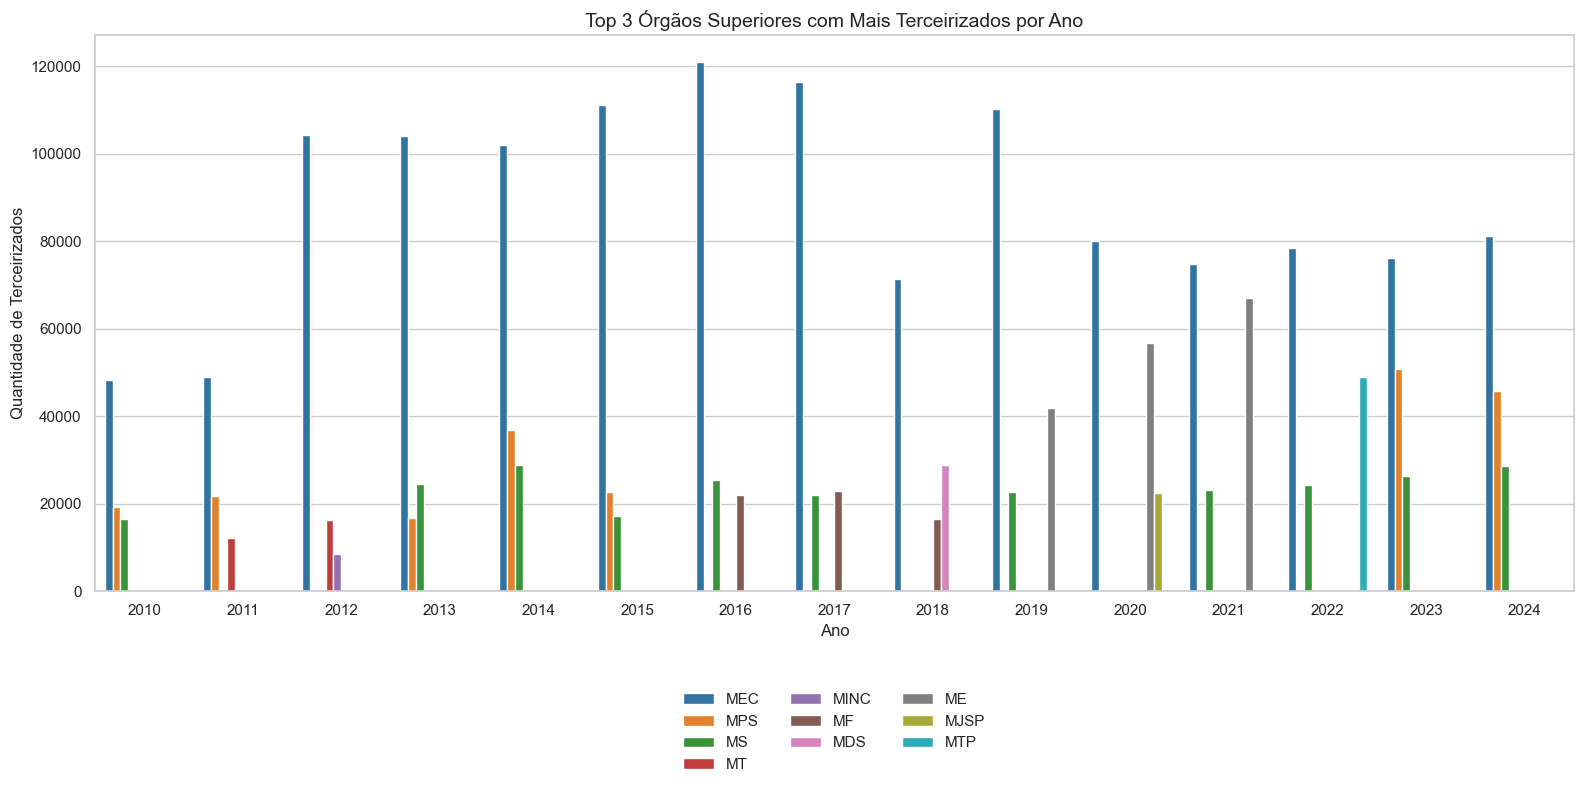

In [67]:
plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_orgaos_por_ano,
    x="Ano_Carga",
    y="qtd_terceirizados",
    hue="sg_orgao_sup_tabela_ug",
    dodge=True,
    palette="tab10"
)

plt.title("Top 3 Órgãos Superiores com Mais Terceirizados por Ano", fontsize=14)
plt.ylabel("Quantidade de Terceirizados")
plt.xlabel("Ano")

plt.legend(
    title=None,
    bbox_to_anchor=(0.5, -0.35),
    loc='lower center',
    ncol=3,
    frameon=False
)

plt.subplots_adjust(bottom=0.2)

plt.tight_layout()

# Caminho e nome do arquivo
#plt.savefig("./graficos/top3_orgaos_qtd_terceirizados_ano.png", dpi=300)  # Salva em alta resolução

plt.show()

### Os maiores custos mensais de terceirizados por órgão

In [68]:
# Aplica o mapeamento às siglas
df_final_cbo['sg_orgao_sup_tabela_ug'] = df_final_cbo['sg_orgao_sup_tabela_ug'].replace(mapa_orgaos)

# Agrupa por ano e órgão superior, somando o custo mensal
df_top_orgaos = (
    df_final_cbo
    .groupby(['Ano_Carga', 'sg_orgao_sup_tabela_ug'], as_index=False)
    .agg({'vl_mensal_custo': 'sum'})
)

# Pega os 10 órgãos com maior custo total acumulado no período
orgaos_top_10 = (
    df_top_orgaos
    .groupby('sg_orgao_sup_tabela_ug')['vl_mensal_custo']
    .sum()
    .nlargest(10)
    .index
)

# Filtra apenas os top 10
df_top_orgaos = df_top_orgaos[df_top_orgaos['sg_orgao_sup_tabela_ug'].isin(orgaos_top_10)]

In [69]:
df_top_orgaos

,Ano_Carga,sg_orgao_sup_tabela_ug,vl_mensal_custo
5,2010,MDS,"6,454,219.56"
6,2010,ME,"2,492,784.67"
7,2010,MEC,"76,097,479.89"
8,2010,MF,"10,531,987.23"
10,2010,MINC,"14,797,397.01"
...,...,...,...
292,2024,MEC,"411,444,282.00"
296,2024,MINC,"23,603,905.00"
298,2024,MJSP,"30,053,275.00"
303,2024,MPS,"173,165,020.00"


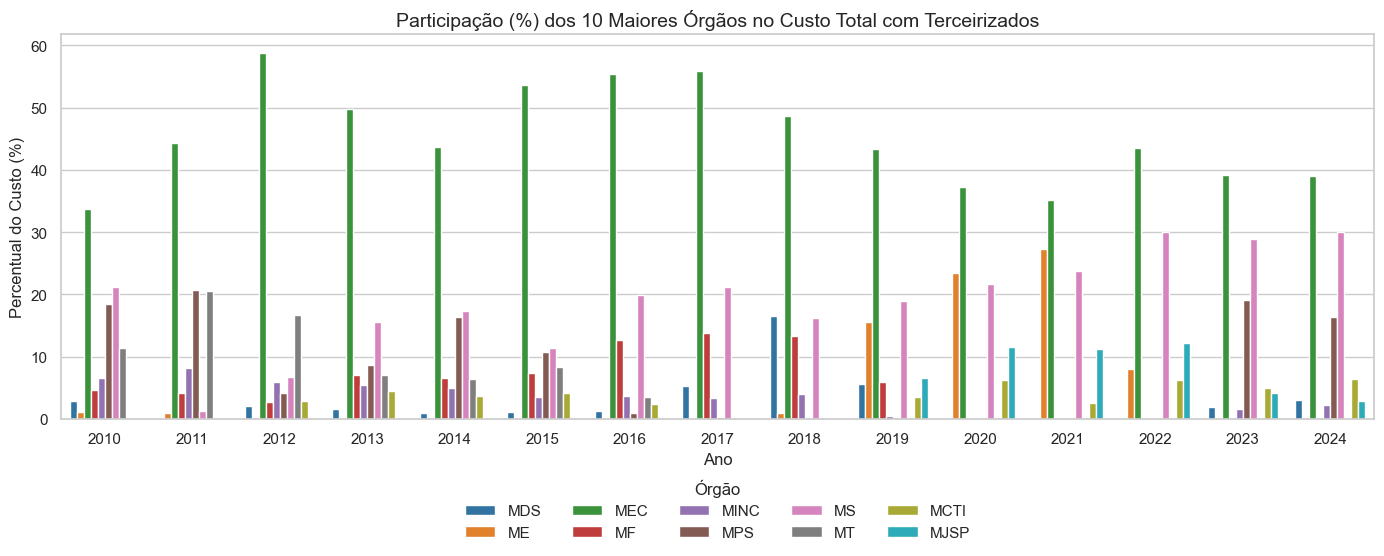

In [71]:
df_top_orgaos_pct = df_top_orgaos.copy()
df_top_orgaos_pct['custo_total_ano'] = df_top_orgaos_pct.groupby('Ano_Carga')['vl_mensal_custo'].transform('sum')
df_top_orgaos_pct['pct_custo'] = df_top_orgaos_pct['vl_mensal_custo'] / df_top_orgaos_pct['custo_total_ano'] * 100

plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_top_orgaos_pct,
    x='Ano_Carga',
    y='pct_custo',
    hue='sg_orgao_sup_tabela_ug',
    palette='tab10'
)
plt.title("Participação (%) dos 10 Maiores Órgãos no Custo Total com Terceirizados", fontsize=14)
plt.ylabel("Percentual do Custo (%)")
plt.xlabel("Ano")
plt.legend(title="Órgão", bbox_to_anchor=(0.5, -0.35), loc='lower center', ncol=5, frameon=False)

plt.tight_layout()

# Caminho e nome do arquivo
#plt.savefig("./graficos/participacao_pct_custo_total.png", dpi=300)  # Salva em alta resolução

plt.show()

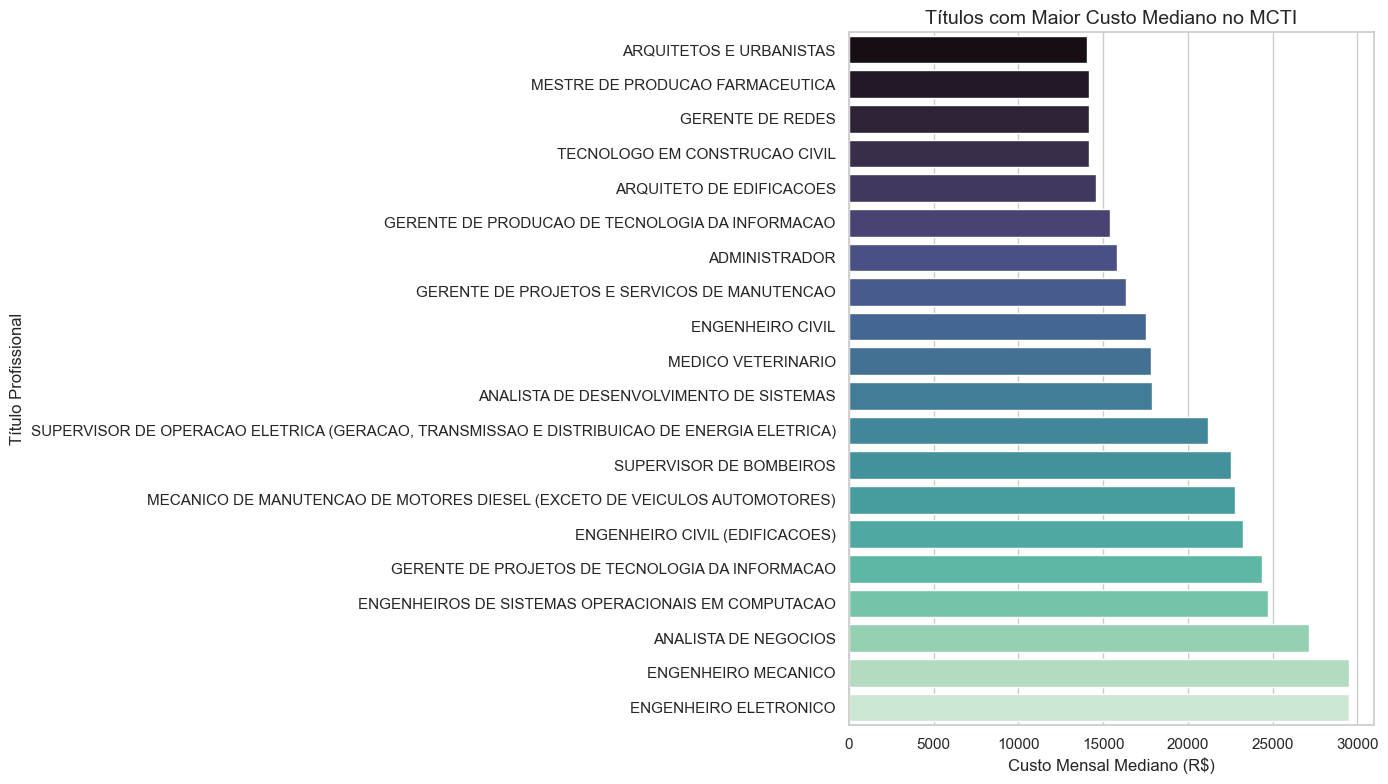

In [93]:
# Maiores custos para o MCTI
# Filtra apenas registros do MCTI
df_mcti = df_final_cbo[df_final_cbo['sg_orgao_sup_tabela_ug'] == 'MCTI'].copy()

# Agrupa por título e calcula a média do custo mensal
df_custo_medio_mcti = (
    df_mcti.groupby('cbo_titulo', as_index=False)['vl_mensal_custo']
    .median()  # você pode trocar para .mean() se preferir média
    .sort_values('vl_mensal_custo', ascending=True)
)

# Pega os 20 maiores custos médios
top_custos = df_custo_medio_mcti.tail(20)

# Gráfico
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_custos,
    x='vl_mensal_custo',
    y='cbo_titulo',
    hue='cbo_titulo',
    palette='mako',
    dodge=False,
    legend=False
)

plt.title("Títulos com Maior Custo Mediano no MCTI", fontsize=14)
plt.xlabel("Custo Mensal Mediano (R$)")
plt.ylabel("Título Profissional")
plt.tight_layout()

# Caminho e nome do arquivo
#plt.savefig("./graficos/custo_mediano_mcti.png", dpi=300)  # Salva em alta resolução

plt.show()

In [72]:
# Estatísticas por órgão e ano
grupo_stats = (
    df_final_cbo
    .groupby(['Ano_Carga', 'sg_orgao_sup_tabela_ug'])['vl_mensal_custo']
    .describe()[['count', 'mean', '50%', 'max']]
    .rename(columns={'50%': 'median'})
    .reset_index()
)

# Cria uma razão entre o valor máximo e a mediana para detectar discrepâncias
grupo_stats['razao_max_mediana'] = grupo_stats['max'] / grupo_stats['median']

# Visualiza os casos com maior discrepância
grupo_stats.sort_values('razao_max_mediana', ascending=False).head(10)

,Ano_Carga,sg_orgao_sup_tabela_ug,count,mean,median,max,razao_max_mediana
7,2010,MEC,"48,218.00","1,578.20","1,476.82","174,658.00",118.27
28,2011,MEC,"48,995.00","2,120.62","1,611.59","170,294.00",105.67
3,2010,MDA,"5,696.00","2,803.21","1,674.18","164,402.00",98.20
17,2010,MS,"16,536.00","2,907.81","2,245.14","193,424.00",86.15
36,2011,MPS,"21,620.00","2,235.59","1,785.28","127,426.00",71.38
16,2010,MPS,"19,330.00","2,162.01","1,655.04","81,371.02",49.17
57,2012,MPOG,"3,152.00","2,332.49","2,000.05","93,601.18",46.80
71,2013,MEC,"104,123.00","2,479.56","2,055.42","74,884.80",36.43
255,2022,MEC,"78,407.00","4,436.29","4,099.42","144,387.00",35.22
150,2016,MS,"25,469.00","5,933.55","4,925.63","161,000.00",32.69


### Custo mensal ao longo dos anos das categorias profissionais com a maior quantidade de terceirizados

In [73]:
df_final_cbo['cbo_titulo'].value_counts().nlargest(10)

VIGILANTE                                      620298
FAXINEIRO                                      334094
SERVENTE                                       102327
AUXILIAR DE SERVICOS GERAIS                    101530
RECEPCIONISTA, EM GERAL                         97853
ASSISTENTE ADMINISTRATIVO                       95262
AUXILIAR DE ESCRITORIO                          80363
RECEPCIONISTA                                   74740
OPERADOR DE TELEMARKETING ATIVO E RECEPTIVO     61461
COPEIRO                                         51422
Name: cbo_titulo, dtype: int64

In [74]:
grupo_1 = [
    'VIGILANTE',
    'FAXINEIRO',
    'SERVENTE',
    'AUXILIAR DE SERVICOS GERAIS',
    'RECEPCIONISTA, EM GERAL'
]

In [75]:
df_grupo_1 = df_final_cbo[df_final_cbo['cbo_titulo'].isin(grupo_1)]

df_mediana_1 = (
    df_grupo_1
    .groupby(['Ano_Carga', 'cbo_titulo'])['vl_mensal_custo']
    .median()
    .reset_index()
)

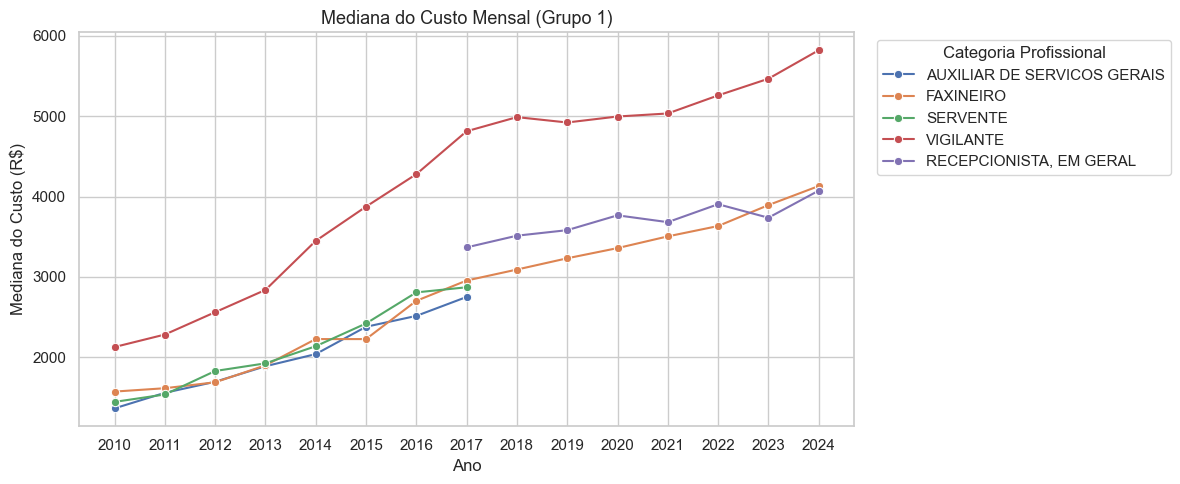

In [77]:
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_mediana_1,
    x='Ano_Carga',
    y='vl_mensal_custo',
    hue='cbo_titulo',
    marker='o'
)
plt.title('Mediana do Custo Mensal (Grupo 1)', fontsize=13)
plt.xlabel('Ano')
plt.ylabel('Mediana do Custo (R$)')
plt.legend(title='Categoria Profissional', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

# Caminho e nome do arquivo
#plt.savefig("./graficos/mediana_custo_mensal_1.png", dpi=300)  # Salva em alta resolução

plt.show()

In [78]:
grupo_2 = [
    'ASSISTENTE ADMINISTRATIVO',
    'AUXILIAR DE ESCRITORIO',
    'RECEPCIONISTA',
    'OPERADOR DE TELEMARKETING ATIVO E RECEPTIVO',
    'COPEIRO'
]

In [79]:
df_grupo_2 = df_final_cbo[df_final_cbo['cbo_titulo'].isin(grupo_2)]

df_mediana_2 = (
    df_grupo_2
    .groupby(['Ano_Carga', 'cbo_titulo'])['vl_mensal_custo']
    .median()
    .reset_index()
)

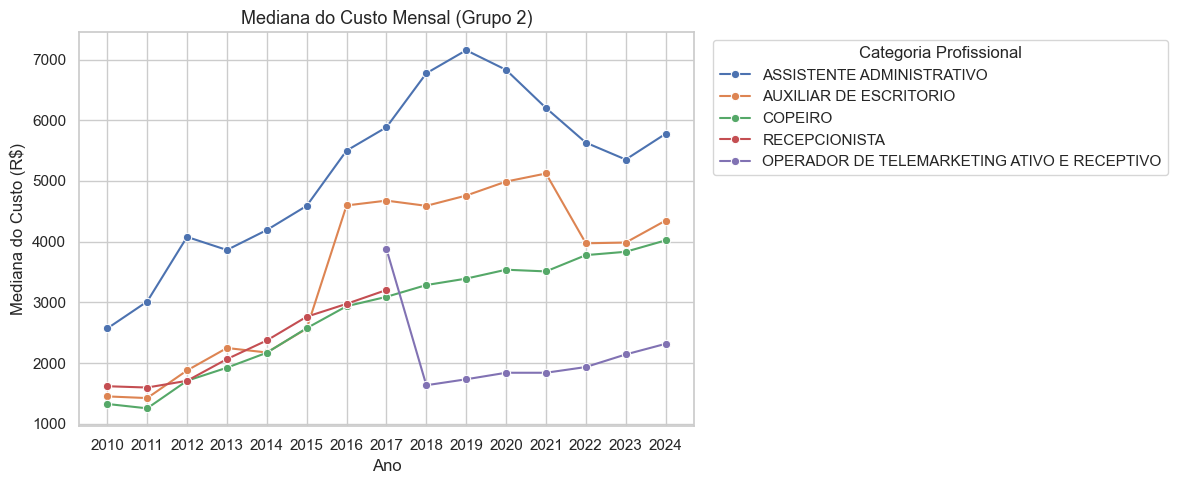

In [81]:
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_mediana_2,
    x='Ano_Carga',
    y='vl_mensal_custo',
    hue='cbo_titulo',
    marker='o'
)
plt.title('Mediana do Custo Mensal (Grupo 2)', fontsize=13)
plt.xlabel('Ano')
plt.ylabel('Mediana do Custo (R$)')
plt.legend(title='Categoria Profissional', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

# Caminho e nome do arquivo
#plt.savefig("./graficos/mediana_custo_mensal_2.png", dpi=300)  # Salva em alta resolução

plt.show()

### Remuneração ao longo dos anos das categorias profissionais com a maior quantidade de terceirizados

In [82]:
df_salario_1 = (
    df_grupo_1
    .groupby(['Ano_Carga', 'cbo_titulo'])['vl_mensal_salario']
    .median()
    .reset_index()
)

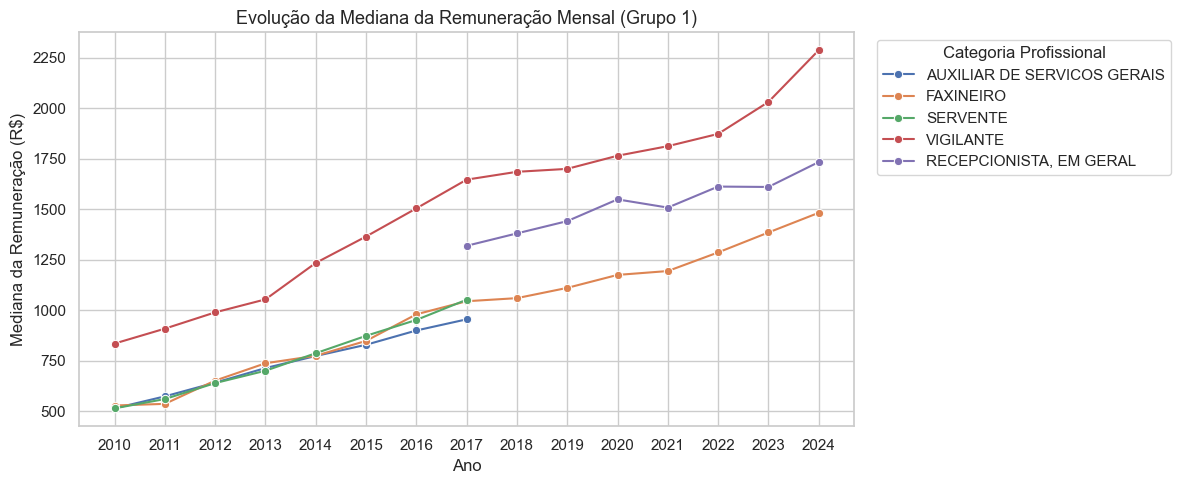

In [84]:
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_salario_1,
    x='Ano_Carga',
    y='vl_mensal_salario',
    hue='cbo_titulo',
    marker='o'
)
plt.title('Evolução da Mediana da Remuneração Mensal (Grupo 1)', fontsize=13)
plt.xlabel('Ano')
plt.ylabel('Mediana da Remuneração (R$)')
plt.legend(title='Categoria Profissional', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

# Caminho e nome do arquivo
#plt.savefig("./graficos/mediana_remuneracao_mensal_1.png", dpi=300)  # Salva em alta resolução

plt.show()

In [85]:
df_salario_2 = (
    df_grupo_2
    .groupby(['Ano_Carga', 'cbo_titulo'])['vl_mensal_salario']
    .median()
    .reset_index()
)

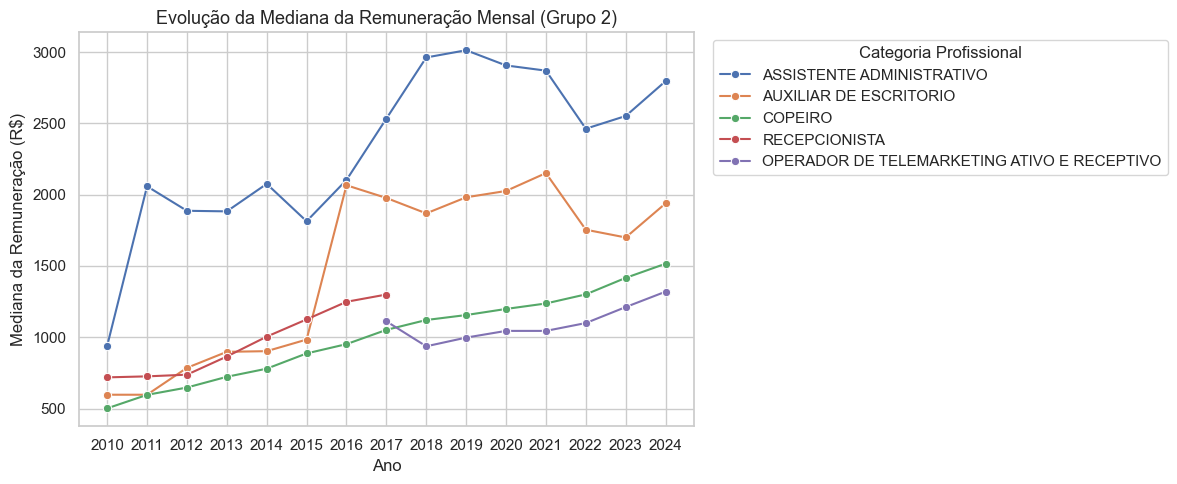

In [87]:
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_salario_2,
    x='Ano_Carga',
    y='vl_mensal_salario',
    hue='cbo_titulo',
    marker='o'
)
plt.title('Evolução da Mediana da Remuneração Mensal (Grupo 2)', fontsize=13)
plt.xlabel('Ano')
plt.ylabel('Mediana da Remuneração (R$)')
plt.legend(title='Categoria Profissional', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

# Caminho e nome do arquivo
#plt.savefig("./graficos/mediana_remuneracao_mensal_2.png", dpi=300)  # Salva em alta resolução

plt.show()